In [262]:
import pandas as pd 
import csv 
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
import sktime 
from datetime import timedelta
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL

register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")
import seaborn as sns
import shap
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [263]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
weekly_sales = pd.read_csv('weekly_sales.csv')
weekly_sales = weekly_sales.set_index('Day')
weekly_sales.index = pd.to_datetime(weekly_sales.index)
weekly_sales.head()

,Sales (USD),Wash (USD),Trade Profit,Supply,Eth price (USD),Bitcoin price,Gas Price,Anomalies,Seller Buyer ratio,Wash Transaction ratio
Day,,,,,,,,,,
2019-01-01,4416.38,8.35,0.00,4030.0,139.61,3809.4,14.330651,0,0.648148,0.004587
2019-01-02,6189.77,2685.46,38.61,125.0,152.95,3873.8,13.518334,0,1.225806,0.050360
2019-01-03,5486.61,1492.68,2.21,1417.0,146.94,3780.1,12.695511,0,1.222222,0.021277
2019-01-04,8053.08,843.21,1.51,1438.0,152.86,3802.7,14.197164,0,0.937500,0.036000
2019-01-05,6769.97,423.57,172.86,136.0,153.49,3785.4,24.120227,0,0.858824,0.048485


In [317]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
colorscales = px.colors.named_colorscales()

corr = weekly_sales.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.Portland,
                                  hoverinfo="none", 
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")

fig.update_layout(
    #title_text='Correlation Heatmap', 
    title_x=0.5, 
    width=900, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

for i in range(len(fig.layout.annotations)):
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

#fig.show()

<AxesSubplot:xlabel='Day'>

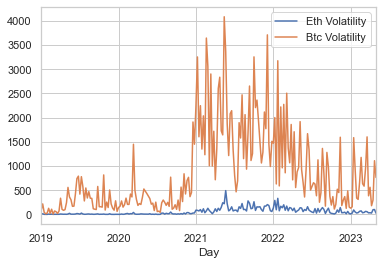

In [318]:
min_max = weekly_sales.resample('W').agg(['max', 'min'])
volatility = pd.DataFrame()
volatility['Eth Volatility'] = weekly_sales['Eth price (USD)'].resample('W').std()
volatility['Btc Volatility'] = weekly_sales['Bitcoin price'].resample('W').std()
weekly_sum = weekly_sales.resample('W').sum()
weekly_sales_final = weekly_sum
weekly_sales_final = weekly_sales_final.drop(['Anomalies','Supply','Seller Buyer ratio',
                                              'Eth price (USD)','Bitcoin price','Gas Price'],axis=1)
volatility.plot()

weekly_sales_final['Sales (USD) weekly max'] = min_max[('Sales (USD)', 'max')].values
weekly_sales_final['Sales (USD) weekly min'] = min_max[('Sales (USD)', 'min')]

weekly_sales_final['Trade Profit Max'] = min_max[('Trade Profit', 'max')]
weekly_sales_final['Trade Profit Min'] = min_max[('Trade Profit', 'min')]

weekly_sales_final['Eth Max'] = min_max[('Eth price (USD)', 'max')]
weekly_sales_final['Eth Min'] = min_max[('Eth price (USD)', 'min')]

weekly_sales_final['Wash (USD) Max'] = min_max[('Eth price (USD)', 'max')]
#weekly_sales_final['Wash (USD) Min'] = min_max[('Eth price (USD)', 'min')]

weekly_sales_final['Bitcoin Max'] = min_max[('Bitcoin price', 'max')]
weekly_sales_final['Bitcoin Min'] = min_max[('Bitcoin price', 'min')]

#weekly_sales_final['Gas Max'] = min_max[('Gas Price', 'max')]
weekly_sales_final['Gas Min'] = min_max[('Gas Price', 'min')]

In [319]:
weekly_sales_final['Sales (USD) weekly max'] = min_max[('Sales (USD)', 'max')].values 
weekly_sales_final['Sales (USD) weekly min'] = min_max[('Sales (USD)', 'min')]
weekly_sales_final['Trade Profit Max'] = min_max[('Trade Profit', 'max')] 
weekly_sales_final['Trade Profit Min'] = min_max[('Trade Profit', 'min')]
#weekly_sales_final['Eth Volatility'] = min_max[('Eth price (USD)', 'max')] 
weekly_sales_final['Wash (USD) Max'] = min_max[('Eth price (USD)', 'max')] 
#weekly_sales_final['Bitcoin Volatility'] = min_max[('Bitcoin price', 'max')] 

In [320]:
keywords = pd.read_csv('NFT Keywords.csv')
print(list(keywords.columns))

['Week', 'NFT Art ', 'bored ape yatch club nft', 'crypto giveaway twitter', 'crypto', 'Cryptocurrency', 'cryptozoo nft', 'free nft', 'is nft a scam', 'nft bored ape', 'nft discord', 'nft giveaway', 'nft marketplace', 'nft scam', 'nft wash trading', 'opensea discord', 'opensea nft', 'wash sale crypto', 'twitter nft', 'twitter giveaway', 'rug pull nft', 'opensea phishing', 'Ethereum', 'NFT', 'opensea marketplace', 'Blockchain', 'Ethereum ', 'Bitcoin']


In [321]:
keywords_group = pd.DataFrame(columns = ['Neutral Phrases', 'Basic', 'Negative'])

keywords_group['Neutral Phrases'] = (keywords['NFT Art '] + keywords['bored ape yatch club nft'] + 
                                    + keywords['crypto'] + keywords['cryptozoo nft']  +
                                     + keywords['nft discord'] 
                                    + keywords['nft marketplace'] + keywords['opensea discord'] 
                                    + keywords['opensea nft']
                                    + keywords['opensea marketplace']) / 9
                    
keywords_group['Basic'] =  (keywords['Blockchain']+ keywords['Ethereum'] + keywords['Bitcoin'] +
                           keywords['NFT'] + keywords['Cryptocurrency']) / 5

keywords_group['Negative'] = (keywords['is nft a scam'] + keywords['nft scam'] + keywords['nft wash trading']
                             + keywords['wash sale crypto'] + keywords['rug pull nft'] + 
                              keywords['opensea phishing']
        + keywords['free nft'] + keywords['crypto giveaway twitter'] + keywords['twitter giveaway']) / 9

In [322]:
weekly_sales_final['Neutral Phrases'] = keywords_group['Neutral Phrases'].values
weekly_sales_final['Basic'] = keywords_group['Basic'].values
weekly_sales_final['Negative'] = keywords_group['Negative'].values
weekly_sales_final = weekly_sales_final.round(decimals =3)

In [323]:
weekly_sales_final.columns

Index(['Sales (USD)', 'Wash (USD)', 'Trade Profit', 'Wash Transaction ratio',
       'Sales (USD) weekly max', 'Sales (USD) weekly min', 'Trade Profit Max',
       'Trade Profit Min', 'Wash (USD) Max', 'Neutral Phrases', 'Basic',
       'Negative'],
      dtype='object')

weekly_sales_corr = weekly_sales_final
weekly_sales_corr['Wash (USD) lag'] = weekly_sales_final['Wash (USD)'].shift(1)
weekly_sales_corr

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
colorscales = px.colors.named_colorscales()

corr = weekly_sales_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask).round(2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.Portland,
                                  hoverinfo="none", 
                                  showscale=True, ygap=1, xgap=1
                                 )

fig.update_xaxes(side="bottom")

fig.update_layout(
    #title_text='Correlation Heatmap', 
    title_x=0.5, 
    width=900, 
    height=700,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

for i in range(len(fig.layout.annotations)):
    if fig.layout.annotations[i].text == 'nan':
        fig.layout.annotations[i].text = ""

fig.show()

## Spillover

In [324]:
sales_google_trends = weekly_sales_final[['Sales (USD)','Neutral Phrases','Basic','Negative']].copy()

In [325]:
sales_google_trends

,Sales (USD),Neutral Phrases,Basic,Negative
Day,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444
2019-01-13,4.428804e+04,0.667,4.6,12.000
2019-01-20,5.891602e+04,6.778,4.0,2.889
2019-01-27,8.476375e+04,4.556,4.0,5.556
2019-02-03,9.789842e+04,0.778,4.4,5.000
2019-02-10,9.949225e+04,0.556,4.0,4.222
2019-02-17,6.945935e+04,0.667,4.8,6.111
2019-02-24,6.260647e+04,3.222,4.4,3.556
2019-03-03,8.712302e+04,0.556,4.0,7.111


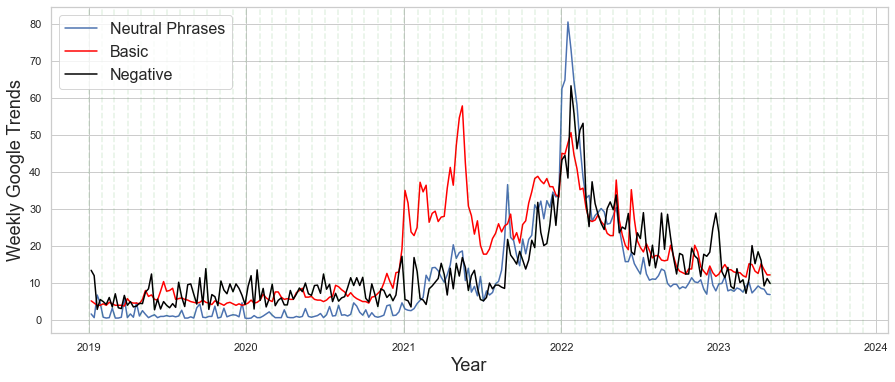

In [326]:
plt.figure(figsize=(15,6))
neutral, = plt.plot(sales_google_trends['Neutral Phrases'])
basic, = plt.plot(sales_google_trends['Basic'], color='red')
negative, = plt.plot(sales_google_trends['Negative'], color='black')

plt.xlabel('Year',fontsize=18)
plt.ylabel('Weekly Google Trends',fontsize=18)
for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.1)

plt.legend(['Neutral Phrases', 'Basic','Negative'], fontsize=16)

In [327]:
avg = sales_google_trends.mean()
dev = sales_google_trends.std()

In [278]:
#for col in sales_google_trends.columns:
#    sales_google_trends[col] = (sales_google_trends[col] - avg.loc[col]) / dev.loc[col]

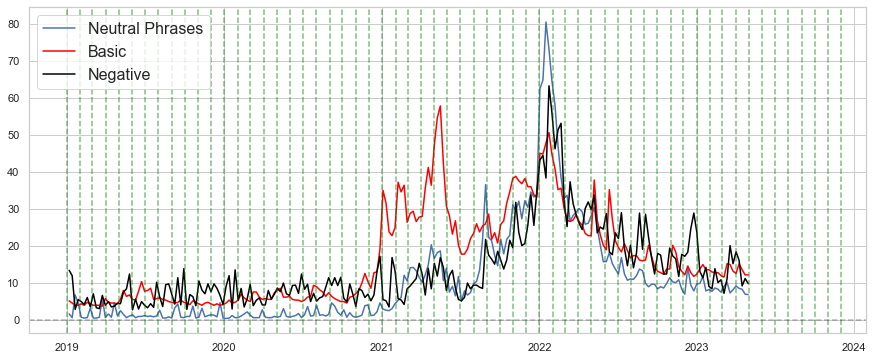

In [328]:
plt.figure(figsize=(15,6))
neutral, = plt.plot(sales_google_trends['Neutral Phrases'])
basic, = plt.plot(sales_google_trends['Basic'], color='red')
negative, = plt.plot(sales_google_trends['Negative'], color='black')

for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.5)

plt.xlabel('')
plt.axhline(0, linestyle='--', color='k', alpha=0.3)        
plt.legend(['Neutral Phrases', 'Basic','Negative'], fontsize=16)

In [280]:
sales_google_trends

,Sales (USD),Neutral Phrases,Basic,Negative
Day,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444
2019-01-13,4.428804e+04,0.667,4.6,12.000
2019-01-20,5.891602e+04,6.778,4.0,2.889
2019-01-27,8.476375e+04,4.556,4.0,5.556
2019-02-03,9.789842e+04,0.778,4.4,5.000
2019-02-10,9.949225e+04,0.556,4.0,4.222
2019-02-17,6.945935e+04,0.667,4.8,6.111
2019-02-24,6.260647e+04,3.222,4.4,3.556
2019-03-03,8.712302e+04,0.556,4.0,7.111


In [281]:
#sales_google_trends = sales_google_trends.diff().dropna()

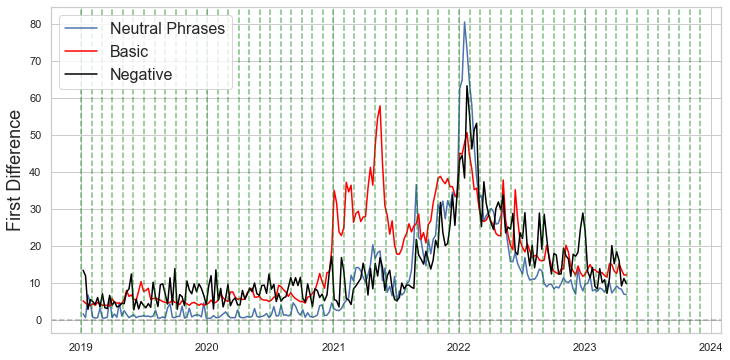

In [329]:
plt.figure(figsize=(12,6))
neutral, = plt.plot(sales_google_trends['Neutral Phrases'])
basic, = plt.plot(sales_google_trends['Basic'], color='red')
negative, = plt.plot(sales_google_trends['Negative'], color='black')

for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.5)

plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)
plt.legend(['Neutral Phrases', 'Basic','Negative'], fontsize=16)

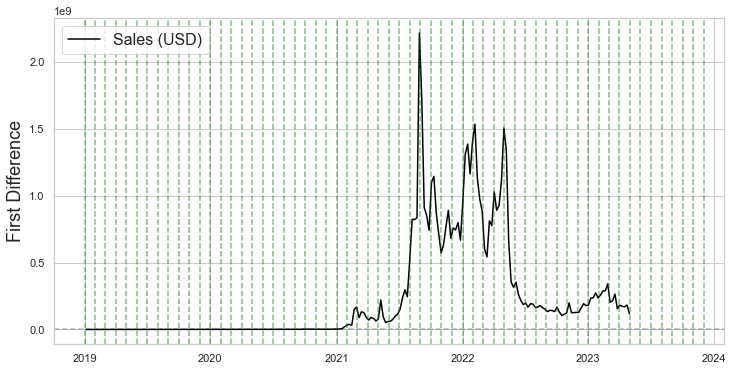

In [330]:
plt.figure(figsize=(12,6))

sales, = plt.plot(sales_google_trends['Sales (USD)'], color='black')

for month in range(1, 13):
    for year in range(2019, 2024):
        plt.axvline(datetime(year,month,1), linestyle='--', color='green', alpha=0.5)

plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)
plt.legend(['Sales (USD)'], fontsize=16)

In [284]:
sales_google_trends

,Sales (USD),Neutral Phrases,Basic,Negative
Day,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444
2019-01-13,4.428804e+04,0.667,4.6,12.000
2019-01-20,5.891602e+04,6.778,4.0,2.889
2019-01-27,8.476375e+04,4.556,4.0,5.556
2019-02-03,9.789842e+04,0.778,4.4,5.000
2019-02-10,9.949225e+04,0.556,4.0,4.222
2019-02-17,6.945935e+04,0.667,4.8,6.111
2019-02-24,6.260647e+04,3.222,4.4,3.556
2019-03-03,8.712302e+04,0.556,4.0,7.111


## Weekly Volatility

In [285]:
#monthly_volatility = sales_google_trends.groupby(sales_google_trends.index.month).std()
#monthly_volatility.head()

In [286]:
#sales_google_trends['monthly_sales_vol'] = sales_google_trends.index.map(lambda d: monthly_volatility.loc[d.month, 'Sales (USD)'])
#sales_google_trends['monthly_neutral_trends'] = sales_google_trends.index.map(lambda d: monthly_volatility.loc[d.month, 'Neutral Phrases'])
#sales_google_trends['monthly_basic_trends'] = sales_google_trends.index.map(lambda d: monthly_volatility.loc[d.month, 'Basic'])
#sales_google_trends['monthly_negative_trends'] = sales_google_trends.index.map(lambda d: monthly_volatility.loc[d.month, 'Negative'])

In [287]:
sales_google_trends

,Sales (USD),Neutral Phrases,Basic,Negative
Day,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444
2019-01-13,4.428804e+04,0.667,4.6,12.000
2019-01-20,5.891602e+04,6.778,4.0,2.889
2019-01-27,8.476375e+04,4.556,4.0,5.556
2019-02-03,9.789842e+04,0.778,4.4,5.000
2019-02-10,9.949225e+04,0.556,4.0,4.222
2019-02-17,6.945935e+04,0.667,4.8,6.111
2019-02-24,6.260647e+04,3.222,4.4,3.556
2019-03-03,8.712302e+04,0.556,4.0,7.111


In [331]:
google_trends = sales_google_trends

google_trends['Sales (USD)'] = sales_google_trends['Sales (USD)'] / sales_google_trends['monthly_sales_vol']

google_trends['Neutral Phrases'] = sales_google_trends['Neutral Phrases'] / sales_google_trends['monthly_neutral_trends']
    
google_trends['Basic'] = sales_google_trends['Basic'] / sales_google_trends['monthly_basic_trends']

google_trends['Negative'] = sales_google_trends['Negative'] / sales_google_trends['monthly_negative_trends']


google_trends[['Sales (USD)','Neutral Phrases', 'Basic','Negative']].plot()

In [332]:
google_trends

,Sales (USD),Neutral Phrases,Basic,Negative
Day,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444
2019-01-13,4.428804e+04,0.667,4.6,12.000
2019-01-20,5.891602e+04,6.778,4.0,2.889
2019-01-27,8.476375e+04,4.556,4.0,5.556
2019-02-03,9.789842e+04,0.778,4.4,5.000
2019-02-10,9.949225e+04,0.556,4.0,4.222
2019-02-17,6.945935e+04,0.667,4.8,6.111
2019-02-24,6.260647e+04,3.222,4.4,3.556
2019-03-03,8.712302e+04,0.556,4.0,7.111


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

plot_pacf(google_trends['Sales (USD)'])
plt.show()

for lag in range(1, 5):
    sales = google_trends['Sales (USD)'].iloc[lag:]
    lagged_negative = google_trends['Negative'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(sales,lagged_negative))
    print('------')

list_cols = list(google_trends.columns)
list_cols = list_cols[1:5]
list_cols

for col in range(0, len(list_cols)):
    for lagged in range(0, len(list_cols)):
        for lag in range(1,2):
            sales = google_trends[list_cols[col]].iloc[lag:]
            lagged_negative = google_trends[list_cols[lagged]].iloc[:-lag]
            print('Lag: %s'%lag)
            print('Effect of %s on %s',list_cols[lagged], list_cols[col])
            print(pearsonr(sales,lagged_negative))
            print('------')

# Sales google trends

sales_google_trends['Neutral Phrases lag'] = sales_google_trends['Neutral Phrases'].shift(1)
sales_google_trends['Basic lag'] = sales_google_trends['Basic'].shift(1)
sales_google_trends['Negative lag'] = sales_google_trends['Negative'].shift(1)
sales_google_trends

plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(sales_google_trends.corr(), vmin=0, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

from statsmodels.tsa.stattools import adfuller
result = adfuller(sales_google_trends['Sales (USD)'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 1
print('Lagged Negative granger causing sales')
test_result = grangercausalitytests(sales_google_trends[['Sales (USD)', 'Negative']], max_lag, verbose=True)

print('Lagged Basic granger causing sales')
test_result = grangercausalitytests(sales_google_trends[['Sales (USD)', 'Basic']], max_lag, verbose=True)

print('Lagged Neutral granger causing sales')
test_result = grangercausalitytests(sales_google_trends[['Sales (USD)', 'Neutral Phrases']], max_lag, verbose=True)

print('Lagged Sales granger causing negative')
test_result = grangercausalitytests(sales_google_trends[['Negative','Sales (USD)']], max_lag, verbose=True)

print('Lagged sales granger causing basic')
test_result = grangercausalitytests(sales_google_trends[['Basic', 'Sales (USD)']], max_lag, verbose=True)

print('Lagged Sales granger causing neutral')
test_result = grangercausalitytests(sales_google_trends[['Neutral Phrases','Sales (USD)']], max_lag, verbose=True)

google_trends_granger = sales_google_trends
google_trends_granger = google_trends_granger.drop(['Neutral Phrases lag', 'Basic lag','Negative lag'],axis=1)
google_trends_granger

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 10
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
grangers_causation_matrix(google_trends_granger, variables = google_trends_granger.columns)

grangers_causation_matrix(google_trends_granger, variables = google_trends_granger.columns)

In [334]:
google_trends_granger = sales_google_trends

# create figure and axis objects with subplots()
fig,ax = plt.subplots(1,1,figsize=(16,9), dpi= 80)
# make a plot
ax.plot(google_trends_granger.index.values,
        google_trends_granger['Sales (USD)'].values,
        color="red")
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Weekly Sales (USD)",
              color="red",
              fontsize=18)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(google_trends_granger.index.values, google_trends_granger['Negative'].values,color="blue")
ax2.set_ylabel("Google Trends (Negative)",color="blue",fontsize=18)
plt.show()



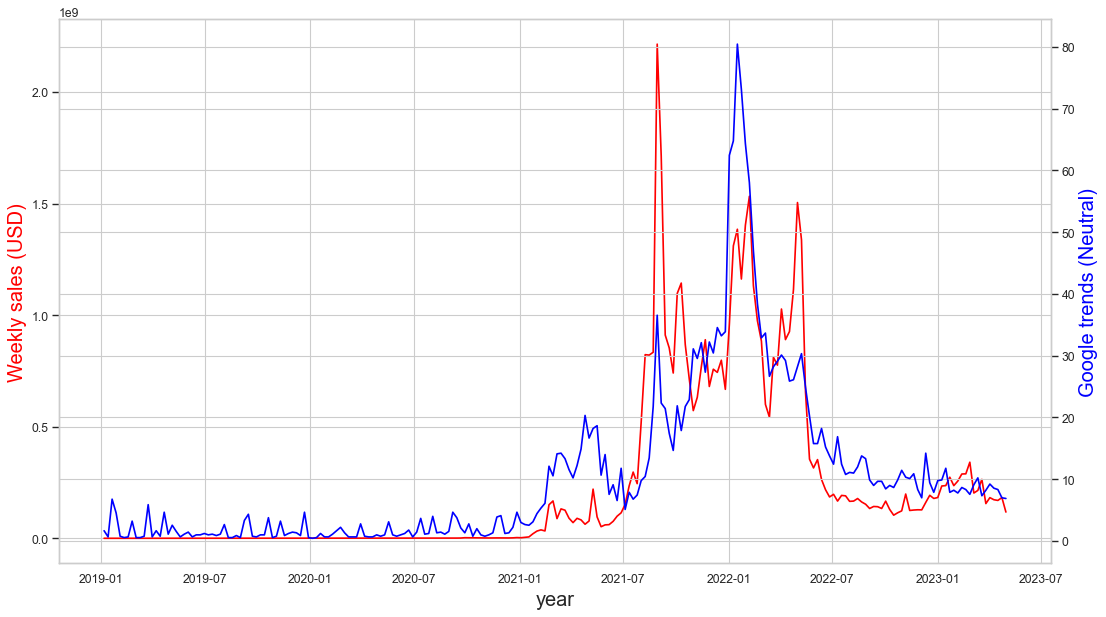

In [335]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(1,1,figsize=(16,9), dpi= 80)
# make a plot
ax.plot(google_trends_granger.index.values,
        google_trends_granger['Sales (USD)'].values,
        color="red")
# set x-axis label
ax.set_xlabel("year", fontsize = 18)
# set y-axis label
ax.set_ylabel("Weekly sales (USD)",
              color="red",
              fontsize=18)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(google_trends_granger.index.values, google_trends_granger['Neutral Phrases'].values,color="blue")
ax2.set_ylabel("Google trends (Neutral)",color="blue",fontsize=18)
plt.show()



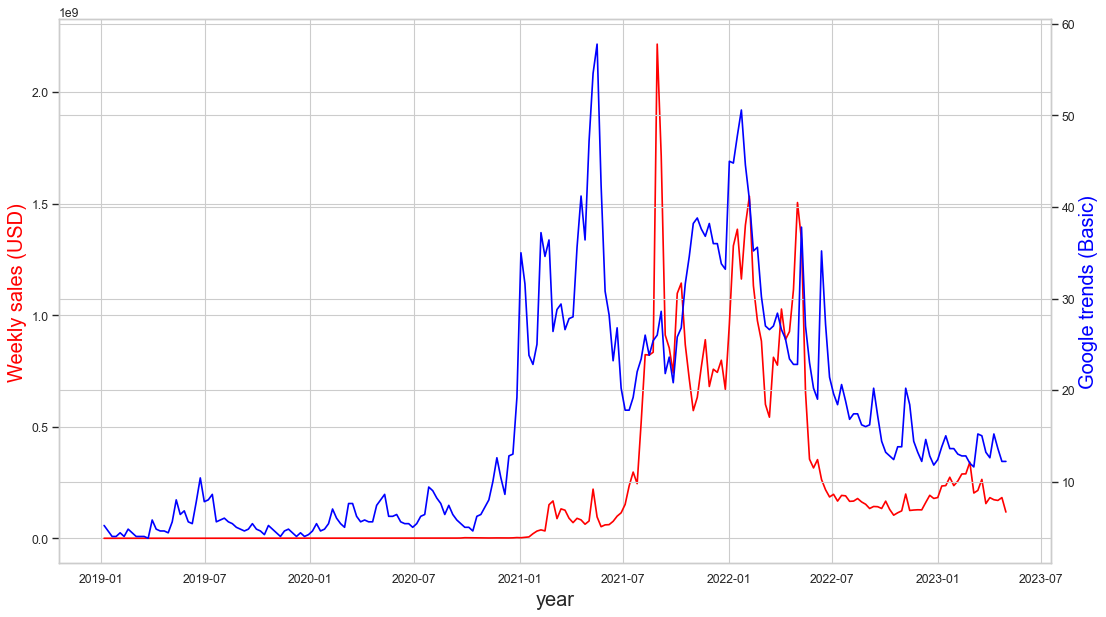

In [336]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(1,1,figsize=(16,9), dpi= 80)
# make a plot
ax.plot(google_trends_granger.index.values,
        google_trends_granger['Sales (USD)'].values,
        color="red")
# set x-axis label
ax.set_xlabel("year", fontsize = 18)
# set y-axis label
ax.set_ylabel("Weekly sales (USD)",
              color="red",
              fontsize=18)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(google_trends_granger.index.values, google_trends_granger['Basic'].values,color="blue")
ax2.set_ylabel("Google trends (Basic)",color="blue",fontsize=18)
plt.show()



In [337]:
google_trends_granger_final = google_trends_granger.join(volatility)
google_trends_granger_final

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Day,,,,,,
2019-01-06,3.793567e+04,1.667,5.2,13.444,5.845856,85.939547
2019-01-13,4.428804e+04,0.667,4.6,12.000,14.770279,218.531308
2019-01-20,5.891602e+04,6.778,4.0,2.889,3.241137,45.054993
2019-01-27,8.476375e+04,4.556,4.0,5.556,1.765290,14.706218
2019-02-03,9.789842e+04,0.778,4.4,5.000,1.912945,27.526109
2019-02-10,9.949225e+04,0.556,4.0,4.222,8.369464,128.019913
2019-02-17,6.945935e+04,0.667,4.8,6.111,4.525560,23.373051
2019-02-24,6.260647e+04,3.222,4.4,3.556,7.518873,108.728620
2019-03-03,8.712302e+04,0.556,4.0,7.111,2.422030,8.473629


In [338]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 2
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [339]:
grangers_causation_matrix(google_trends_granger_final, variables = google_trends_granger_final.columns)

,Sales (USD)_x,Neutral Phrases_x,Basic_x,Negative_x,Eth Volatility_x,Btc Volatility_x
Sales (USD)_y,1.0000,0.0000,0.0643,0.0196,0.2296,0.1117
Neutral Phrases_y,0.6244,1.0000,0.0350,0.3946,0.2132,0.2122
Basic_y,0.0318,0.0101,1.0000,0.1834,0.0021,0.0093
Negative_y,0.0000,0.0000,0.0004,1.0000,0.0315,0.3127
Eth Volatility_y,0.0000,0.0000,0.0000,0.0001,1.0000,0.0047
Btc Volatility_y,0.0000,0.0001,0.0000,0.0770,0.0671,1.0000


## Cointegration Test

In [340]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Your data preparation step
# mdata is assumed to be previously defined
# data = mdata[["realgdp","realcons", "realinv"]].pct_change().dropna()

def cointegration_test(data, alpha=0.05): 
    """
    Perform Johansen's Cointegration Test and Report Summary
    """
    
    # Perform the Johansen Test
    out = coint_johansen(data, -1, 5)
    
    # Significance levels: keys are p-values, values are critical values
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): 
        return str(val).ljust(length)
    
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# Run the cointegration test
cointegration_test(google_trends_granger_final)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales (USD) ::  114.1     > 83.9383   =>   True
Neutral Phrases ::  63.71     > 60.0627   =>   True
Basic  ::  32.45     > 40.1749   =>   False
Negative ::  17.8      > 24.2761   =>   False
Eth Volatility ::  8.05      > 12.3212   =>   False
Btc Volatility ::  0.6       > 4.1296    =>   False


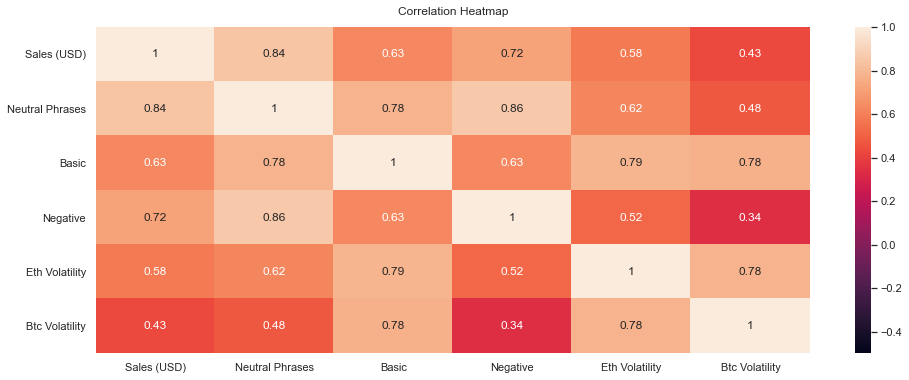

In [341]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(google_trends_granger_final.corr(), vmin=-0.5, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

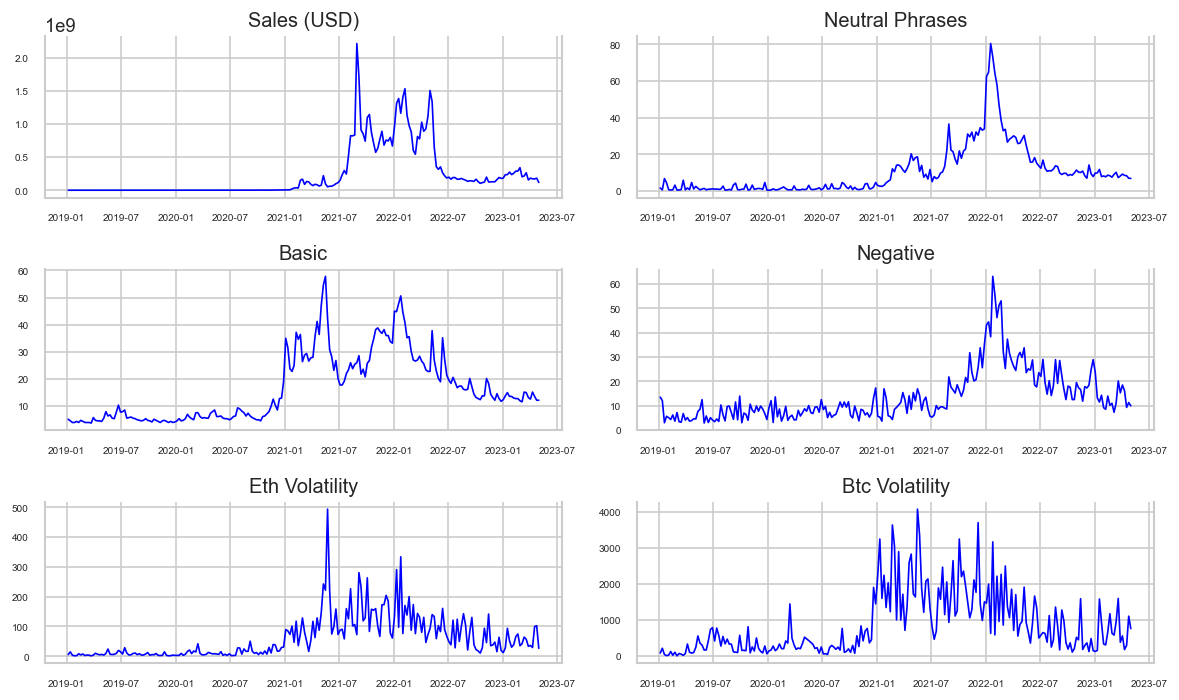

In [342]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = google_trends_granger_final[google_trends_granger_final.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(google_trends_granger_final.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [343]:
import scipy.stats as stats

stat,p = stats.normaltest(google_trends_granger_final['Sales (USD)'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 108.741, p=0.000
Data looks non-Gaussian (reject null hypothesis


In [344]:
import scipy.stats as stats

stat,p = stats.normaltest(google_trends_granger_final['Basic'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 28.721, p=0.000
Data looks non-Gaussian (reject null hypothesis


In [345]:
import scipy.stats as stats

stat,p = stats.normaltest(google_trends_granger_final['Neutral Phrases'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 133.689, p=0.000
Data looks non-Gaussian (reject null hypothesis


In [346]:
import scipy.stats as stats

stat,p = stats.normaltest(google_trends_granger_final['Negative'])
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Statistics = 95.703, p=0.000
Data looks non-Gaussian (reject null hypothesis


for cols in google_trends_granger_final.columns:
    plt_acf(google_trends_granger_final[i], lags = 4)
    plt.title('ACF for %s' % col)
    plt.show()

# VAR

In [347]:
n_obs=10
X_train, X_test = google_trends_granger_final[0:-n_obs], google_trends_granger_final[-n_obs:]
print(X_train.shape, X_test.shape)

(216, 6) (10, 6)


In [348]:
transform_data = google_trends_granger_final.diff().dropna()
transform_data

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Day,,,,,,
2019-01-13,6.352370e+03,-1.000,-0.6,-1.444,8.924423,132.591761
2019-01-20,1.462798e+04,6.111,-0.6,-9.111,-11.529143,-173.476315
2019-01-27,2.584773e+04,-2.222,0.0,2.667,-1.475847,-30.348775
2019-02-03,1.313467e+04,-3.778,0.4,-0.556,0.147655,12.819891
2019-02-10,1.593830e+03,-0.222,-0.4,-0.778,6.456519,100.493804
2019-02-17,-3.003290e+04,0.111,0.8,1.889,-3.843904,-104.646862
2019-02-24,-6.852880e+03,2.555,-0.4,-2.555,2.993313,85.355569
2019-03-03,2.451655e+04,-2.666,-0.4,3.555,-5.096843,-100.254992
2019-03-10,1.112250e+05,0.000,0.0,-3.778,1.733037,63.589578


In [349]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
print('Augmented Dickey-Fuller Test: Sales Time Series')
augmented_dickey_fuller_statistics(transform_data['Sales (USD)'])

print('Augmented Dickey-Fuller Test: Neutral Time Series')
augmented_dickey_fuller_statistics(transform_data['Neutral Phrases'])

print('Augmented Dickey-Fuller Test: Basic Time Series')
augmented_dickey_fuller_statistics(transform_data['Basic'])

print('Augmented Dickey-Fuller Test: Negative Time Series')
augmented_dickey_fuller_statistics(transform_data['Negative'])

print('Augmented Dickey-Fuller Test: ETH Volatility Time Series')
augmented_dickey_fuller_statistics(transform_data['Eth Volatility'])

print('Augmented Dickey-Fuller Test: BTC Volatililty')
augmented_dickey_fuller_statistics(transform_data['Btc Volatility'])

print()
print("Original DF \n")

print('Augmented Dickey-Fuller Test: Sales Time Series')
augmented_dickey_fuller_statistics(google_trends_granger_final['Sales (USD)'])

print('Augmented Dickey-Fuller Test: Neutral Time Series')
augmented_dickey_fuller_statistics(google_trends_granger_final['Neutral Phrases'])

print('Augmented Dickey-Fuller Test: Basic Time Series')
augmented_dickey_fuller_statistics(google_trends_granger_final['Basic'])

print('Augmented Dickey-Fuller Test: Negative Time Series')
augmented_dickey_fuller_statistics(google_trends_granger_final['Negative'])

print('Augmented Dickey-Fuller Test: ETH Volatility Time Series')
augmented_dickey_fuller_statistics(google_trends_granger_final['Eth Volatility'])

print('Augmented Dickey-Fuller Test: BTC Volatililty')
augmented_dickey_fuller_statistics(google_trends_granger_final['Btc Volatility'])

Augmented Dickey-Fuller Test: Sales Time Series
ADF Statistic: -13.995272
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Neutral Time Series
ADF Statistic: -4.856482
p-value: 0.000042
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Basic Time Series
ADF Statistic: -6.722637
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Negative Time Series
ADF Statistic: -15.851730
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: ETH Volatility Time Series
ADF Statistic: -8.269466
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: BTC Volatililty
ADF Statistic: -9.144725
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574

Original DF 

Augmented Dickey-Fuller Test: Sales Time Series
ADF Statistic: -2.320922
p-value: 0.165309
Critical V

In [350]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [351]:
for name, column in transform_data.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales (USD)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.9953
 No. Lags Chosen       = 1
 Critical value 1%     = -3.46
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Neutral Phrases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8565
 No. Lags Chosen       = 8
 Critical value 1%     = -3.461
 Critical value 5%     = -2.875
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Basic" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

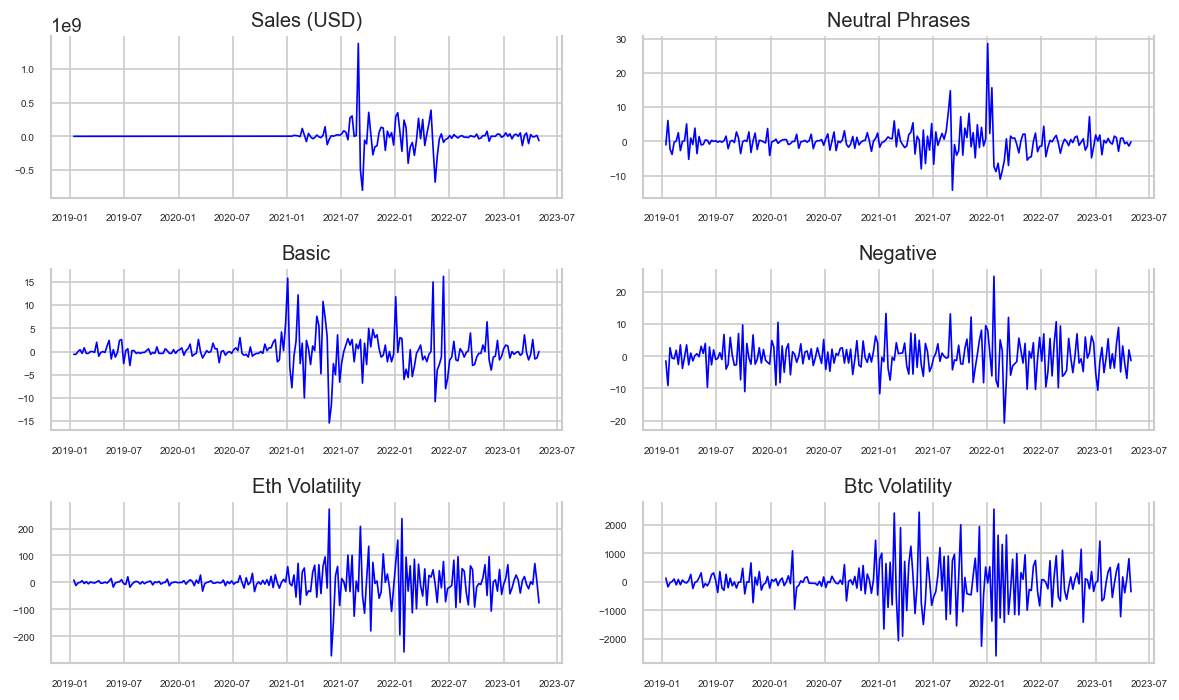

In [352]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = transform_data[transform_data.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(transform_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [309]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 4
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(google_trends_granger_final, variables = transform_data.columns)

,Sales (USD)_x,Neutral Phrases_x,Basic_x,Negative_x,monthly_sales_vol_x,monthly_neutral_trends_x,monthly_basic_trends_x,monthly_negative_trends_x,Eth Volatility_x,Btc Volatility_x
Sales (USD)_y,1.0000,0.0007,0.7809,0.0329,0.2957,0.2023,0.0643,0.1919,0.1888,0.3204
Neutral Phrases_y,0.3933,1.0000,0.2674,0.2276,0.5885,0.1293,0.0601,0.1639,0.2506,0.0944
Basic_y,0.0082,0.0022,1.0000,0.0502,0.2286,0.3137,0.0040,0.3885,0.0001,0.0019
Negative_y,0.2687,0.0000,0.0060,1.0000,0.4247,0.0005,0.0731,0.0005,0.1130,0.0526
monthly_sales_vol_y,0.0480,0.7988,0.0815,0.3321,1.0000,0.8233,0.0003,0.5229,0.0344,0.0689
monthly_neutral_trends_y,0.3601,0.1919,0.0712,0.0591,0.2265,1.0000,0.1444,0.3025,0.1051,0.1106
monthly_basic_trends_y,0.5523,0.3538,0.0205,0.2140,0.8784,0.7938,1.0000,0.1505,0.5317,0.3028
monthly_negative_trends_y,0.7817,0.2652,0.1071,0.1039,0.3030,0.0784,0.5742,1.0000,0.3170,0.2232
Eth Volatility_y,0.0001,0.0002,0.0000,0.3499,0.1007,0.0645,0.0034,0.0501,1.0000,0.0049
Btc Volatility_y,0.0011,0.0031,0.0000,0.0108,0.6725,0.2400,0.3569,0.1555,0.0680,1.0000


In [362]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 4
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            f_stat = [round(test_result[i+1][0][test][0],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, f-statistic Values = {f_stat}')
            min_f_stat = np.min(f_stat)
            df.loc[r, c] = min_f_stat
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(transform_data, variables = transform_data.columns)

,Sales (USD)_x,Neutral Phrases_x,Basic_x,Negative_x,Eth Volatility_x,Btc Volatility_x
Sales (USD)_y,0.0000,11.4990,0.0204,4.5531,0.1436,0.6397
Neutral Phrases_y,0.0019,0.0000,0.8557,0.6061,1.5281,0.0007
Basic_y,5.9286,8.0102,0.0000,2.7296,4.4943,8.7845
Negative_y,0.0480,12.0345,0.6092,0.0000,3.4251,0.0302
Eth Volatility_y,15.3210,15.0556,30.0925,0.8106,0.0000,1.1971
Btc Volatility_y,2.6579,3.6689,36.3641,3.7693,2.2319,-0.0000


In [366]:
model = VAR(transform_data)
#for i in [1,2,3,4,5,6,7,8]:
 #   result = model.fit(i)
  #  print('Lag Order =', i)
   # print('AIC : ', result.aic)
    #print('BIC : ', result.bic)
    #print('FPE : ', result.fpe)
    #print('HQIC: ', result.hqic, '\n')

In [367]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,67.29,67.39,1.682e+29,67.33
1,66.35,67.03*,6.548e+28,66.63
2,65.94,67.21,4.352e+28,66.45*
3,65.76,67.60,3.622e+28,66.50
4,65.74,68.17,3.572e+28,66.72
5,65.61,68.62,3.162e+28,66.83
6,65.68,69.28,3.417e+28,67.13
7,65.73,69.91,3.654e+28,67.42
8,65.67,70.44,3.510e+28,67.60
9,65.27,70.62,2.413e+28,67.44


In [359]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Aug, 2023
Time:                     13:24:10
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    65.5793
Nobs:                     225.000    HQIC:                   65.1990
Log likelihood:          -9179.50    FPE:                1.59898e+28
AIC:                      64.9416    Det(Omega_mle):     1.33048e+28
--------------------------------------------------------------------
Results for equation Sales (USD)
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const               12993277.550665  21743998.015209            0.598           0.550
L1.Sales (USD)             0.775252         0.047266           16.402           0.000
L1.Neutral Phrases   6874385.44931

In [314]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(google_trends_granger_final.columns, out):
    print(col, ':', round(val, 2))

Sales (USD) : 2.09
Neutral Phrases : 1.99
Basic : 2.14
Negative : 2.09
monthly_sales_vol : 2.01
monthly_neutral_trends : 1.97
monthly_basic_trends : 1.98
monthly_negative_trends : 2.0
Eth Volatility : 1.98
Btc Volatility : 2.02


In [315]:
# Get the lag order
#lag_order = model_fitted.k_ar
#print(lag_order) 

# Input data for forecasting
forecast_input = transform_data.values[-1:]
forecast_input

array([[-1.98675841e-01,  9.05268555e-02,  1.13298626e-01,
        -3.18236710e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -7.56384288e+01,
        -3.45653604e+02]])

In [316]:
fc = model_fitted.forecast(y=forecast_input, steps=10)
df_forecast = pd.DataFrame(fc, index=google_trends_granger_final.index[-10:], columns=google_trends_granger_final.columns + '_2d')
df_forecast

ValueError: y must by have at least order (5) observations. Got 1.

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(X_train, df_forecast, second_diff=True)       
df_results.loc[:, ['Sales (USD)_forecast', 'Neutral Phrases_forecast', 'Basic_forecast', 'Negative_forecast',
                   'Eth Volatility_forecast', 'Btc Volatility_forecast']]

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Sales (USD)')
accuracy_prod = forecast_accuracy(df_results['Sales (USD)_forecast'].values, X_test['Sales (USD)'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: Neutral Phrases)')
accuracy_prod = forecast_accuracy(df_results['Neutral Phrases_forecast'].values, X_test['Neutral Phrases'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: Basic Phrases)')
accuracy_prod = forecast_accuracy(df_results['Basic_forecast'].values, X_test['Basic'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('Forecast Accuracy of: Negative Phrases)')
accuracy_prod = forecast_accuracy(df_results['Negative_forecast'].values, X_test['Negative'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: ETH Volatility)')
accuracy_prod = forecast_accuracy(df_results['Eth Volatility_forecast'].values, X_test['Eth Volatility'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('Forecast Accuracy of: Bitcoin Volatility)')
accuracy_prod = forecast_accuracy(df_results['Btc Volatility_forecast'].values, X_test['Btc Volatility'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))




## VAR Method 2

lag_order = model_fitted.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-1:]
print(input_data)
# forecasting

pred = model_fitted.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        return forecast
    
output = invert_transformation(X_train, pred)
#combining predicted and real data set
combine = pd.concat([output['Eth Volatility_pred'], X_test['Eth Volatility']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row['Eth Volatility_pred'] /row['Eth Volatility'] *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Day')

combine

var = VAR(google_trends_granger_final)
x= var.select_order()
x.summary()

fitted_model = var.fit(1)
irf = fitted_model.irf(4)
fig = plt.figure(figsize=(40,40))
irf.plot(orth=False)
plt.show()


import statsmodels.tsa.api

results = var.fit(1)
fitted_values = results.fittedvalues
results.summary()
results.plot_forecast(steps=10)


## FINAL VAR

In [368]:
model = VAR(transform_data)
res = model.select_order(15)
res.summary()

,AIC,BIC,FPE,HQIC
0,67.17,67.26,1.479e+29,67.21
1,66.22,66.89*,5.726e+28,66.49
2,65.81,67.05,3.814e+28,66.31*
3,65.62,67.43,3.153e+28,66.35
4,65.60,67.99,3.118e+28,66.57
5,65.47,68.43,2.744e+28,66.67
6,65.53,69.07,2.955e+28,66.96
7,65.59,69.70,3.164e+28,67.25
8,65.54,70.22,3.053e+28,67.43
9,65.15,70.41,2.115e+28,67.27


In [369]:
var_data = np.log(google_trends_granger_final).diff().dropna()
var_data

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Day,,,,,,
2019-01-13,0.154823,-0.915991,-0.122602,-0.113626,0.926884,0.933285
2019-01-20,0.285398,2.318647,-0.139762,-1.423996,-1.516693,-1.579045
2019-01-27,0.363755,-0.397237,0.000000,0.653968,-0.607609,-1.119613
2019-02-03,0.144062,-1.767474,0.095310,-0.105441,0.080329,0.626865
2019-02-10,0.016149,-0.335958,-0.095310,-0.169129,1.475946,1.537051
2019-02-17,-0.359338,0.182022,0.182322,0.369781,-0.614848,-1.700602
2019-02-24,-0.103873,1.574968,-0.087011,-0.541454,0.507675,1.537271
2019-03-03,0.330453,-1.756989,-0.095310,0.693007,-1.132810,-2.551896
2019-03-10,0.822702,0.000000,0.000000,-0.757770,0.539723,2.140585


In [370]:
model = VAR(var_data)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-10.15,-10.05,3.919e-05,-10.11
1,-11.09,-10.43*,1.520e-05,-10.83*
2,-11.23,-10.00,1.323e-05,-10.74
3,-11.44*,-9.640,1.080e-05*,-10.71
4,-11.38,-9.015,1.148e-05,-10.43
5,-11.28,-8.343,1.280e-05,-10.09
6,-11.22,-7.715,1.372e-05,-9.802
7,-11.02,-6.950,1.691e-05,-9.376
8,-10.85,-6.211,2.040e-05,-8.975
9,-10.73,-5.524,2.346e-05,-8.628


In [371]:
results = model.fit(maxlags=15, ic='aic')
lag_order = results.k_ar
print(lag_order)

3


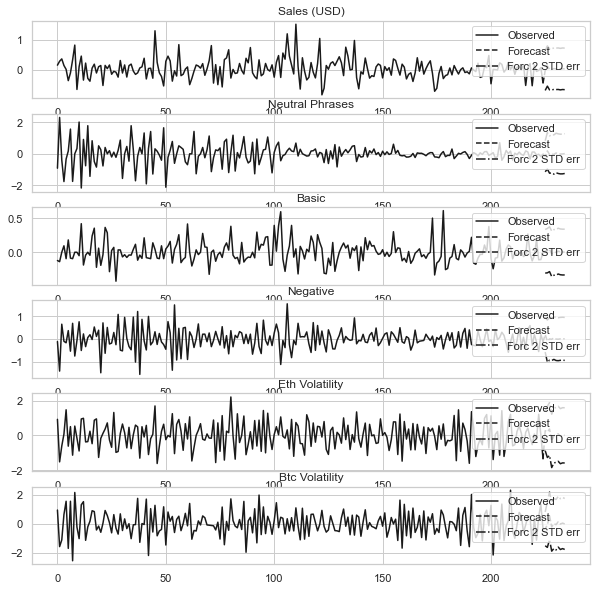

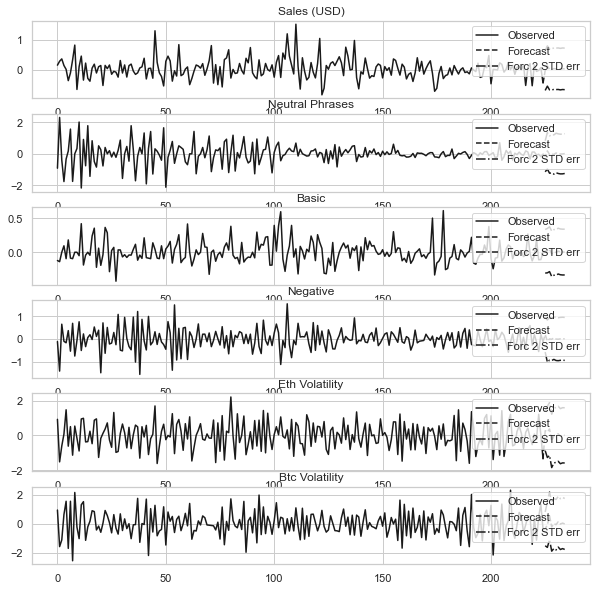

In [372]:
results.plot_forecast(10)

## ADF before

In [373]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in google_trends_granger_final.columns: 
    adf_res = adfuller(google_trends_granger_final[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=google_trends_granger_final.columns).T
adf_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Test statistic,-2.3209,-2.0421,-1.8976,-2.1695,-1.5057,-1.7588
p-value,0.1653,0.2684,0.3332,0.2175,0.5307,0.4011
Critical value - 1%,-3.4600,-3.4610,-3.4606,-3.4600,-3.4611,-3.4610
Critical value - 5%,-2.8746,-2.8750,-2.8748,-2.8746,-2.8751,-2.8750
Critical value - 10%,-2.5737,-2.5740,-2.5739,-2.5737,-2.5740,-2.5740


## KPSS BEFORE

In [374]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in google_trends_granger_final.columns: 
    kpss_res = kpss(google_trends_granger_final[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=google_trends_granger_final.columns).T
kpss_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Test statistic,0.2107,0.2051,0.3316,0.1650,0.3598,0.3624
p-value,0.0120,0.0141,0.0100,0.0341,0.0100,0.0100
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190,0.1190


## ADF After

In [375]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in transform_data.columns: 
    adf_res = adfuller(transform_data[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=transform_data.columns).T
adf_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Test statistic,-13.9953,-4.8565,-6.7226,-15.8517,-8.2695,-9.1447
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Critical value - 1%,-3.4600,-3.4610,-3.4607,-3.4600,-3.4611,-3.4608
Critical value - 5%,-2.8746,-2.8750,-2.8749,-2.8746,-2.8751,-2.8750
Critical value - 10%,-2.5737,-2.5740,-2.5739,-2.5737,-2.5740,-2.5739


## KPSS After

In [376]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in transform_data.columns: 
    kpss_res = kpss(transform_data[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=transform_data.columns).T
kpss_res_df.round(4)

,Sales (USD),Neutral Phrases,Basic,Negative,Eth Volatility,Btc Volatility
Test statistic,0.0657,0.0447,0.0674,0.074,0.1018,0.0859
p-value,0.1000,0.1000,0.1000,0.100,0.1000,0.1000
Critical value - 1%,0.2160,0.2160,0.2160,0.216,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160,0.216,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460,0.146,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.119,0.1190,0.1190


In [387]:
model_fin = VAR(transform_data)
x = model_fin.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,67.06,67.16,1.334e+29,67.10
1,66.10,66.76*,5.113e+28,66.37
2,65.70,66.92,3.401e+28,66.19*
3,65.49,67.28,2.788e+28,66.22
4,65.48,67.83,2.764e+28,66.43
5,65.35,68.26,2.426e+28,66.52
6,65.40,68.88,2.591e+28,66.81
7,65.45,69.49,2.744e+28,67.08
8,65.39,70.00,2.636e+28,67.26
9,64.99,70.16,1.799e+28,67.08


In [388]:
var_model = model_fin.fit(2)

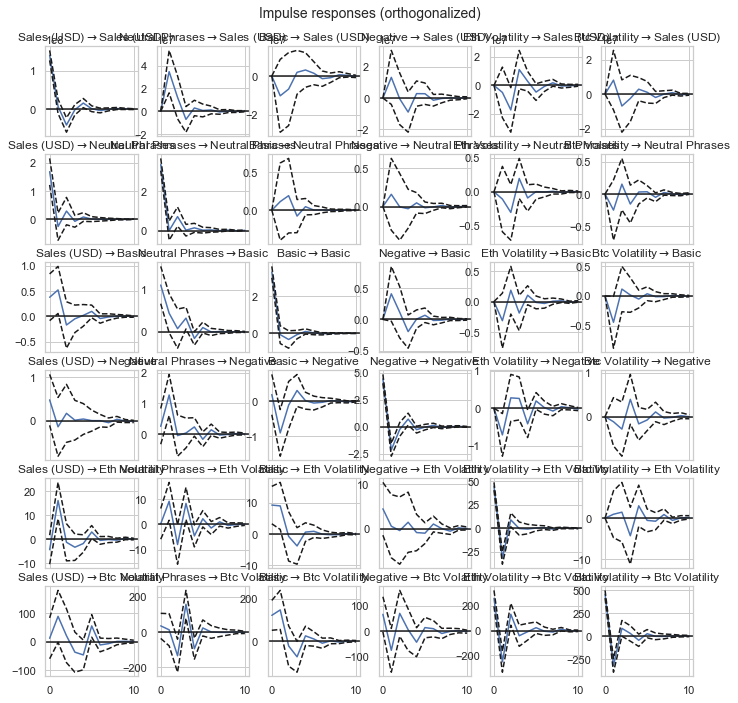

In [392]:
irf = var_model.irf(periods=10)
ax = irf.plot(orth=True, figsize=(10, 10),subplot_params={'fontsize':12})

In [386]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 4
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(google_trends_granger_final, variables = transform_data.columns)

,Sales (USD)_x,Neutral Phrases_x,Basic_x,Negative_x,Eth Volatility_x,Btc Volatility_x
Sales (USD)_y,0.0000,13.4565,3.4226,4.0672,0.9111,2.5296
Neutral Phrases_y,0.1969,0.0000,4.4431,0.2233,1.5493,1.5565
Basic_y,1.9508,1.5803,0.0000,1.0777,9.0633,4.1826
Negative_y,11.9050,68.2283,9.9896,0.0000,1.3471,1.0191
Eth Volatility_y,26.0713,27.5878,87.6942,3.3515,0.0000,6.7587
Btc Volatility_y,9.0637,9.2420,67.4717,2.8794,3.0155,0.0000


In [391]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    maxlag = 2
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(transform_data, variables = transform_data.columns)

,Sales (USD)_x,Neutral Phrases_x,Basic_x,Negative_x,Eth Volatility_x,Btc Volatility_x
Sales (USD)_y,1.0000,0.0007,0.7809,0.0329,0.1307,0.2083
Neutral Phrases_y,0.7075,1.0000,0.2674,0.2276,0.1641,0.9350
Basic_y,0.0138,0.0047,1.0000,0.0502,0.0245,0.0021
Negative_y,0.5310,0.0000,0.4351,1.0000,0.0500,0.0427
Eth Volatility_y,0.0000,0.0001,0.0000,0.2573,1.0000,0.1696
Btc Volatility_y,0.0055,0.0261,0.0000,0.0522,0.1195,1.0000


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = sal[transform_data.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    ax.set_title(transform_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();